# Svenskt Kvinnobiografiskt lexikon part 3
version part 3 - 1.10


* this [Jupyter Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb) 
  * [part 1](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon.ipynb) check Wikidata and SKBL
  * [part 2](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%202.ipynb) more queries etc.
* [video](https://www.youtube.com/watch?v=6jxH8MBIhvg) in Swedish about how SKBL deliver and work with Wikidata
  * Example how project Women in Red at en:Wikipedia automatic [creates list](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW) that shows what in SKBL has an english article about a women but not have an english article in en:Wikipedia
    * see [version history](https://en.wikipedia.org/w/index.php?title=Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW&action=history) of list created
    * see en:Wikipedia articles [with a link to SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 680 articles

# Get metadata from SKBL and use it on the articles using Wikidata
Test getting the author data from SKBL  

If we get this data with license [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) "No rights reserved" we can store it in [Wikidata](https://www.wikidata.org/wiki/Wikidata:Licensing) and use it on all > 1500 articles in [sv:Wikipedia](https://sv.wikipedia.org/wiki/Kategori:SKBL) and [en:Wikipedia](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) using the [template SKBL](https://en.wikipedia.org/wiki/Template:SKBL) see also [Template Talk SKBL](https://en.wikipedia.org/wiki/Template_talk:SKBL#Store_author_in_Wikidata_and_use_in_the_SKBL_template) 

and display who the author is of the article in SKBL e.g. 
* Nauman, Sari [Ulrika Eleonora d.y., drottning](https://skbl.se/en/article/UlrikaEleonoradydrottning) at [Svenskt kvinnobiografiskt lexikon](https://en.wikipedia.org/wiki/Svenskt_kvinnobiografiskt_lexikon)

**See also**
* video [Introduction to WIkidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

# Wikidata

In [1]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 
from datetime import datetime

now = datetime.now()
print("Last run: ", now)
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

querySKBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?skblid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P4963 ?skblid
} order by ?skbl"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSKBLtot = get_sparql_dataframe(endpoint_url, querySKBL)
WDSKBLtot["Source"] = "SKBL" 


Last run:  2020-09-04 17:01:55.668861


In [2]:
WDSKBLtot.sort_index(inplace=True)  

In [3]:
WDSKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478 entries, 0 to 1477
Data columns (total 3 columns):
wid       1478 non-null object
skblid    1478 non-null object
Source    1478 non-null object
dtypes: object(3)
memory usage: 34.8+ KB


In [4]:
import csv  
import urllib3, json
http = urllib3.PoolManager() 

jsonURL = "https://skbl.se/sv/artikel/"
listNewItems =[]
for index,row in WDSKBLtot.iterrows():
    url = jsonURL + row["skblid"] + ".json"
    r = http.request('GET', url) 
    data = json.loads(r.data.decode('utf-8'))  
    new_item = dict()
    new_item['skblid'] = row["skblid"]
    new_item['wid'] = row["wid"]
    try:
        publishedDate = data['publication_date']        
    except:
        publishedDate =""
    new_item['publishedDate'] = publishedDate
    try:
        article_author_firstname = data['article_author'][0]['firstname']
    except:
        article_author_firstname =""
    new_item['article_author_firstname'] = article_author_firstname
    try:
        article_author_lastname = data['article_author'][0]['lastname']
    except:
        article_author_lastname =""
    new_item['article_author_lastname'] = article_author_lastname
    try:
        subtitle_sv = data['subtitle']
    except:
        subtitle_sv =""
    new_item['subtitle_sv'] = subtitle_sv
    try:
        subtitle_eng = data['subtitle_eng']
    except:
        subtitle_eng =""
    new_item['subtitle_eng'] = subtitle_eng
    try:
        name_lastname = data['name']['lastname']
    except:
        name_lastname = ""
    new_item['name_lastname'] = name_lastname
    try:
        name_firstname = data['name']['firstname']
    except:
        name_firstname = ""
    new_item['name_firstname'] = name_firstname
    listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")


1478  antal poster


In [5]:
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SKBLAuthor_newfile.csv", "w", newline='') as SKBLfile:
        dict_writer = csv.DictWriter(SKBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSKBLAuthorcsv = pd.read_csv("SKBLAuthor_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 
            


## Store Authorname in WIkidata 

1. Step nr one is that we just add the author as a text string e.g.
  1. Example article UlrikaEleonoradydrottning has in metadata json see line 1 below  

    1. article_author_firstname: "Sari"
    1. article_author_lastname: "Nauman" 
    
I guess then we create a authorname string **Nauman, Sari**

Many of the authors has an Wikipedia article on Swedish Wikipedia --> then we could add the author as a Wikilink e.g.
Lisbeth Larsson [Q4961115](https://www.wikidata.org/wiki/Q4961115) is same as SKBL [articleauthor/Larsson, Lisbeth](https://skbl.se/en/articleauthor/Larsson%2C%20Lisbeth)  

See also [en:Wikipedia:Template:Talk:SKBL](https://en.wikipedia.org/wiki/Template_talk:SKBL#Store_author_in_Wikidata_and_use_in_the_SKBL_template)

In [6]:
dfSKBLAuthorcsv["publishedDate"] = dfSKBLAuthorcsv["publishedDate"].astype("datetime64")
dfSKBLAuthorcsv["Source"] = "SKBL"

In [7]:
%matplotlib inline    
import matplotlib.pyplot as plt   


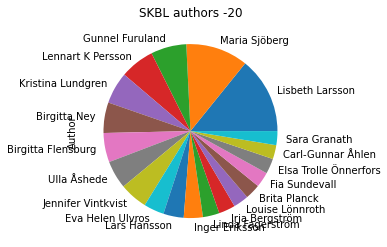

In [37]:
plotPublishedAuthor =   dfSKBLAuthorcsv  
  
plotPublishedAuthor["Author"] = plotPublishedAuthor["article_author_firstname"] + " " + plotPublishedAuthor["article_author_lastname"]   
plotAuthor = plotPublishedAuthor["Author"].value_counts()[:20]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors -20")
plt.show()

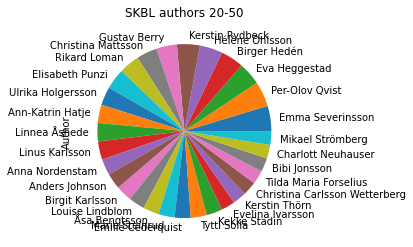

In [38]:
plotAuthor = plotPublishedAuthor["Author"].value_counts()[20:50]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors 20-50")
plt.show()

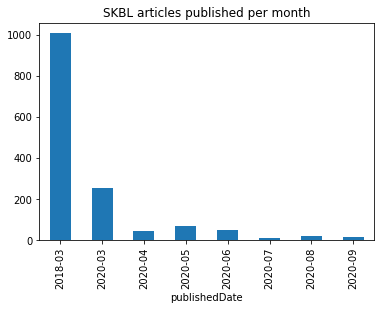

In [40]:
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(df['last_payout'].dt.to_period('M')).sum().plot(kind='bar')
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby([dfSKBLAuthorcsv.publishedDate.year,dfSKBLAuthorcsv.publishedDate.month].agg('count'))
plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(dfSKBLAuthorcsv.publishedDate.dt.to_period("M")).agg('count')
plotPublishedperMonth.plot( kind = 'bar') 
plt.title("SKBL articles published per month")
plt.show()

In [11]:
plotPublishedperMonth

publishedDate
2018-03    1008
2020-03     254
2020-04      47
2020-05      71
2020-06      51
2020-07      11
2020-08      22
2020-09      14
Freq: M, Name: publishedDate, dtype: int64

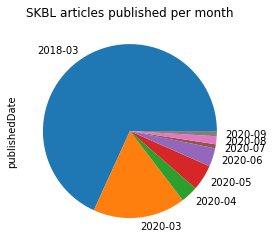

In [41]:
plotPublishedperMonth.plot( kind = 'pie') 
plt.title("SKBL articles published per month")
plt.show()

In [13]:
pd.set_option('display.max_rows', None) 
# Sort latest first 
#dfSKBLAuthorcsv.sort_values(by=['publishedDate'], ascending=[False])

In [14]:
from IPython.display import display, HTML  
plotPublishedAuthor['Link'] = plotPublishedAuthor['skblid'].apply(lambda x: "https://skbl.se/sv/artikel/{0}".format(x))  
plotPublishedAuthor.style.set_properties(subset=['publishedDate'], **{'width': '200px'}) 
plotPublishedAuthor = plotPublishedAuthor.sort_values(by=['publishedDate'], ascending=[False])
plotPublishedAuthor = plotPublishedAuthor.reset_index(drop=True)  
plotPublishedAuthor[:10]

,skblid,wid,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,subtitle_eng,name_lastname,name_firstname,Source,Author,Link
0,BarbroKerstinElisabetSoderberg,Q98894908,2020-09-04,Anna-Malin,Karlsson,"Professor, språkvetare","Professor, language researcher",Söderberg,/Barbro/ Kerstin Elisabet,SKBL,Anna-Malin Karlsson,https://skbl.se/sv/artikel/BarbroKerstinElisab...
1,MarianneLindsten,Q4962945,2020-09-04,Jan,Thomasson,"Provinsialläkare, pionjär, kvinnosakskvinna","Pioneering district medical officer, proponent...",Lindstén,/Marianne/ Charlotta,SKBL,Jan Thomasson,https://skbl.se/sv/artikel/MarianneLindsten
2,ClaraNataliaTeresiaEuren,Q4988449,2020-09-04,Ulrika,Jannert Kallenberg,"Författare, översättare, lärare","Author, translator, teacher",Eurén,Clara Natalia /Teresia/,SKBL,Ulrika Jannert Kallenberg,https://skbl.se/sv/artikel/ClaraNataliaTeresia...
3,CarinWastberg,Q4990774,2020-09-04,Marie,Andersson,"Textilkonstnär, direktör","Textile artist, director",Wästberg,/Carin/ Helena,SKBL,Marie Andersson,https://skbl.se/sv/artikel/CarinWastberg
4,MariaWidebeck,Q33043583,2020-09-03,Marie,Andersson,"Textilkonstnär, formgivare","Textile artist, designer",Widebeck,/Maria/ Cecilia,SKBL,Marie Andersson,https://skbl.se/sv/artikel/MariaWidebeck
5,SaraWennerbergReuter,Q4990297,2020-09-03,Magdalena,Fronczak,"Organist, kompositör, pionjär","Pioneering organist, composer",Wennerberg-Reuter,/Sara/ Margareta Eugenia Eufrosyne,SKBL,Magdalena Fronczak,https://skbl.se/sv/artikel/SaraWennerbergReuter
6,LottenEdholm,Q4945709,2020-09-03,Camilla,Bergvall,"Hovfunktionär, pionjär inom svenska Röda Korse...","Court functionary, pioneer within the Swedish ...",Edholm,Lovisa (/Lotten/) Christina Charlotta,SKBL,Camilla Bergvall,https://skbl.se/sv/artikel/LottenEdholm
7,BirgitCarell,Q98842875,2020-09-03,Johanna,Overud,"Konsulent, beredskapsivrare","Advisory officer, civil defence activist",Carell,Karin Anna /Birgit/,SKBL,Johanna Overud,https://skbl.se/sv/artikel/BirgitCarell
8,EvaFroberg,Q4949121,2020-09-02,Camilla,Bergvall,"Godsägare, politiker, kvinnosakskvinna","Property owner, politician, proponent of women...",Fröberg,/Eva/ Maria,SKBL,Camilla Bergvall,https://skbl.se/sv/artikel/EvaFroberg
9,GallieAkerhielm,Q18275056,2020-09-02,Ulrika,Jannert Kallenberg,"Författare, journalist, översättare","Author, journalist, translator",Åkerhielm,/Gallie/,SKBL,Ulrika Jannert Kallenberg,https://skbl.se/sv/artikel/GallieAkerhielm


## Compare SBL
SBL started in 1918 and is published by the [National Archives](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en) in Sweden. They have
* No API
* focus on publish on paper
* dont have structured data
* no understanding of [Linked data](https://vimeo.com/36752317)
* we have before manually and doing webscrabing populated [Wikidata P3217](https://www.wikidata.org/wiki/Property_talk:P3217) now I guess we wait on SBL for delivering data as data see question asked [236883](https://phabricator.wikimedia.org/T236883) Oct 30 2019, 11:03 AM - no official answer so far and The Swedish National Archives has no helpdesk system were you get an unique helpdesk number ([some action was promised aug 2018 by Rolf Källman](https://twitter.com/salgo60/status/1030269242296414208?s=20) nothing heard)


In [15]:
# SPARQL 
querySBL = """SELECT distinct (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid  ?genderLabel ?birth ?death WHERE {
?item wdt:P31 wd:Q5.
OPTIONAL {?item wdt:P21 ?gender}
OPTIONAL {?item wdt:P569 ?birth}
OPTIONAL {?item wdt:P570 ?death}
?item wdt:P3217 ?sblid
SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
} order by ?sblid """


WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)
WDSBLtot["Source"] = "SBL" 
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8158 entries, 0 to 8157
Data columns (total 6 columns):
wid            8158 non-null object
sblid          8158 non-null object
genderLabel    8158 non-null object
birth          7918 non-null object
death          8052 non-null object
Source         8158 non-null object
dtypes: object(6)
memory usage: 382.5+ KB


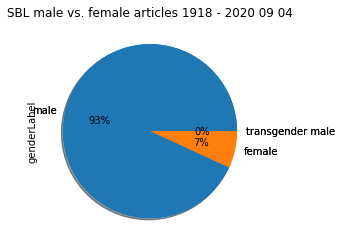

In [42]:
plotSBLgender = WDSBLtot["genderLabel"].value_counts()
plotSBLgender.plot( kind = 'pie') 
plt.title("Riksarkivet SBL male/female")
plot = plotSBLgender.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("SBL male vs. female articles 1918 - " + now.strftime('%Y %m %d'))

plt.show()

In [17]:
plotSBLgender

male                7598
female               559
transgender male       1
Name: genderLabel, dtype: int64

In [18]:
plotSBLfemale = WDSBLtot[WDSBLtot["genderLabel"] == "female"] 
#plotSBLfemale["birth"] = plotSBLfemale["birth"].astype("datetime64")
plotSBLfemale.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559 entries, 7 to 8134
Data columns (total 6 columns):
wid            559 non-null object
sblid          559 non-null object
genderLabel    559 non-null object
birth          558 non-null object
death          556 non-null object
Source         559 non-null object
dtypes: object(6)
memory usage: 30.6+ KB


In [19]:
#Merge dfSKBLAuthorcsv and plotSBLfemale 


In [20]:
end = datetime.now()
print("Ended: ", end)

Ended:  2020-09-04 17:06:03.689762


In [21]:
dfmerge = pd.merge(plotSBLfemale, plotPublishedAuthor,how='outer', on='wid',indicator=True)

In [22]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1714 entries, 0 to 1713
Data columns (total 18 columns):
wid                         1714 non-null object
sblid                       559 non-null object
genderLabel                 559 non-null object
birth                       558 non-null object
death                       556 non-null object
Source_x                    559 non-null object
skblid                      1501 non-null object
publishedDate               1501 non-null datetime64[ns]
article_author_firstname    1499 non-null object
article_author_lastname     1499 non-null object
subtitle_sv                 1501 non-null object
subtitle_eng                1498 non-null object
name_lastname               1465 non-null object
name_firstname              1501 non-null object
Source_y                    1501 non-null object
Author                      1499 non-null object
Link                        1501 non-null object
_merge                      1714 non-null category
dtypes

In [23]:
dfmerge["_merge"].value_counts()

right_only    1155
both           346
left_only      213
Name: _merge, dtype: int64

In [24]:
# both is number in bioth SBL and SKBL   
# right_only is SBL
# left_only is SKBL

In [25]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','SBL_only').str.replace('right_only','SKBL_only')
dfmerge[0:10]

,wid,sblid,genderLabel,birth,death,Source_x,skblid,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,subtitle_eng,name_lastname,name_firstname,Source_y,Author,Link,_merge
0,Q1794132,10025,female,1760-10-01T00:00:00Z,1813-07-17T00:00:00Z,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
1,Q1794132,10025,female,1760-12-07T00:00:00Z,1813-07-17T00:00:00Z,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
2,Q3431866,10043,female,1910-02-24T00:00:00Z,1957-09-04T00:00:00Z,SBL,MarianneLofgren,2018-03-08,Jennifer,Vintkvist,Skådespelare,Actor,Löfgren,Jeannette Wedday /Marianne/ Ida Carolina,SKBL,Jennifer Vintkvist,https://skbl.se/sv/artikel/MarianneLofgren,both
3,Q4964675,10125,female,1887-02-18T00:00:00Z,1918-05-24T00:00:00Z,SBL,HarrietLowenhjelm,2018-03-08,Boel,Hackman,"Författare, konstnär","Author, artist",Löwenhjelm,/Harriet/ Augusta Dorothea,SKBL,Boel Hackman,https://skbl.se/sv/artikel/HarrietLowenhjelm,both
4,Q4942488,10132,female,1855-08-10T00:00:00Z,1932-01-02T00:00:00Z,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
5,Q4965144,10184,female,1864-01-20T00:00:00Z,1942-03-21T00:00:00Z,SBL,MathildaMalling,2018-03-08,Birgitta,Ney,Författare,Author,Malling,Ingrid /Mathilda/,SKBL,Birgitta Ney,https://skbl.se/sv/artikel/MathildaMalling,both
6,Q16595614,10248,female,1867-10-02T00:00:00Z,1914-03-23T00:00:00Z,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
7,Q4968661,10331,female,1529-01-13T00:00:00Z,1609-09-29T00:00:00Z,SBL,EbbaMansdotterLilliehook0,2020-03-02,Jan,Samuelson,"Grevinna, godsägare","Countess, property owner",Månsdotter (Lilliehöök),/Ebba/,SKBL,Jan Samuelson,https://skbl.se/sv/artikel/EbbaMansdotterLilli...,both
8,Q16595619,10332,female,1887-01-24T00:00:00Z,1977-04-24T00:00:00Z,SBL,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBL_only
9,Q4962236,10390,female,1816-07-16T00:00:00Z,1892-09-12T00:00:00Z,SBL,FredrikaCatharinaLimnell,2020-03-02,Birgitta,Jordansson,"Kvinnosakskvinna, salongsvärdinna, mecenat","Proponent of women's issues, hostess of cultur...",Limnell,/Fredrika/ Catharina,SKBL,Birgitta Jordansson,https://skbl.se/sv/artikel/FredrikaCatharinaLi...,both


In [26]:
mergeCheck = dfmerge[['wid', 'sblid','skblid','publishedDate','_merge']] 
mergeCheck.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1714 entries, 0 to 1713
Data columns (total 5 columns):
wid              1714 non-null object
sblid            559 non-null object
skblid           1501 non-null object
publishedDate    1501 non-null datetime64[ns]
_merge           1714 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 80.3+ KB


In [27]:
mergeCheckNumber = mergeCheck["_merge"].value_counts()
mergeCheckNumber

SKBL_only    1155
both          346
SBL_only      213
Name: _merge, dtype: int64

In [28]:
mergeCheckNumber.value_counts

<bound method IndexOpsMixin.value_counts of SKBL_only    1155
both          346
SBL_only      213
Name: _merge, dtype: int64>

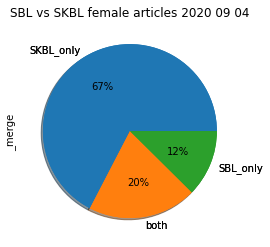

In [29]:
mergeCheckNumber = mergeCheck["_merge"].value_counts()
mergeCheckNumber.plot( kind = 'pie')  
plot = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("SBL vs SKBL female articles " + now.strftime('%Y %m %d'))
plt.show()


In [30]:
mergeCheckNumber

SKBL_only    1155
both          346
SBL_only      213
Name: _merge, dtype: int64

In [31]:
#Profiles missing in SKBL that SBL has written = left_only 
WDSBLonly = mergeCheck[mergeCheck["_merge"] == "SBL_only"].copy() 

In [32]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 555
Data columns (total 5 columns):
wid              213 non-null object
sblid            213 non-null object
skblid           0 non-null object
publishedDate    0 non-null datetime64[ns]
_merge           213 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 10.0+ KB


In [33]:
WDSBLonly["sbl"] = "https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=" + WDSBLonly["sblid"] 
pd.set_option('column_space', 20)
pd.set_option('max_colwidth', 300)

WDSBLonly[["wid","sblid","sbl"]][:10]

,wid,sblid,sbl
0,Q1794132,10025,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10025
1,Q1794132,10025,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10025
4,Q4942488,10132,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10132
6,Q16595614,10248,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10248
8,Q16595619,10332,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10332
10,Q42399094,10396,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10396
12,Q4767223,10404,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10404
13,Q4962366,10417,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10417
14,Q11857592,10445,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10445
26,Q38373456,10673,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10673


### Same query in Wikidata 
* Find all women [in SBL but not in SKBL](https://w.wiki/bFw) = 196 women
* Find all women [in SBL but not in SKBL and have an en:Wikipedia article](https://w.wiki/bFy) = 128 


In [34]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 555
Data columns (total 6 columns):
wid              213 non-null object
sblid            213 non-null object
skblid           0 non-null object
publishedDate    0 non-null datetime64[ns]
_merge           213 non-null object
sbl              213 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 11.6+ KB


In [35]:
WDSBLonly.drop_duplicates(subset ="wid", keep = False, inplace = True)
WDSBLonly.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 4 to 553
Data columns (total 6 columns):
wid              179 non-null object
sblid            179 non-null object
skblid           0 non-null object
publishedDate    0 non-null datetime64[ns]
_merge           179 non-null object
sbl              179 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 9.8+ KB


In [36]:
end = datetime.now()
print("Ended: ", end)

Ended:  2020-09-04 17:09:39.758549
